# Mind the Gap: Metadata Completion for Wellcome Catalogue
```Bash
author Louis Larcher, Arthur Taieb and Cassio Manuguera
```

**Abstract**  
The Wellcome Collection is a vast and culturally diverse set of materials, ranging from medical and ethnographic objects, historical manuscripts, books and journals spanning dozens of cultures and over 50 languages. Its materials range from everyday items to rare documents and artworks, making it a rich resource for understanding health, culture and the human experience across time.

Yet despite the breadth and value of these holdings, many items suffer from missing or incomplete metadata—such as unknown dates, origins or creators—which limits how effectively they can be catalogued, searched or interpreted. Our project aims to address this challenge by developing machine-learning methods to predict or approximate these missing fields using available textual descriptions and, when possible, images. By providing archivists with reliable, data-driven estimates, we seek to help enrich the Wellcome Collection’s records and improve access to its diverse cultural heritage.



In [1]:
from pathlib import Path
import gzip
import json
import pandas as pd
from tqdm.auto import tqdm


def load_wellcome_data_kaggle(n_samples=1000):
    path = Path("/kaggle/input/welcome-dataset/works.json")

    print(f"Loading {n_samples:,} samples from {path}")

    works = []

    # Detect gz or plain json correctly
    open_fn = gzip.open if path.suffix == ".gz" else open

    with open_fn(path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(tqdm(f, total=n_samples)):
            if i >= n_samples:
                break
            try:
                work = json.loads(line)
                works.append(extract_all_fields(work))
            except json.JSONDecodeError:
                continue

    df = pd.DataFrame(works)
    print(f"✓ Loaded {len(df):,} rows")
    return df

def extract_all_fields(work):
    """
    Extract ALL available fields from a work record.
    """
    parsed = {
        # Basic info
        'id': work.get('id'),
        'title': work.get('title'),
        'alternativeTitles': None,
        'workType': work.get('workType', {}).get('label'),
        'workType_id': work.get('workType', {}).get('id'),
        'description': work.get('description'),
        'physicalDescription': work.get('physicalDescription'),
        'lettering': work.get('lettering'),
        'edition': work.get('edition'),
        
        # Production info
        'production_date': None,
        'production_date_from': None,
        'production_date_to': None,
        'production_places': [],
        'production_agents': [],
        'production_function': None,
        
        # Contributors
        'contributors': [],
        'contributor_roles': [],
        'contributor_ids': [],
        
        # Classification
        'subjects': [],
        'subject_ids': [],
        'genres': [],
        'genre_ids': [],
        
        # Languages
        'languages': [],
        'language_ids': [],
        
        # Identifiers
        'identifiers': [],
        'isbn': None,
        'issn': None,
        'sierra_system_number': None,
        'wellcome_library_number': None,
        
        # Notes
        'notes': [],
        'note_types': [],
        
        # Availability
        'thumbnail_url': None,
        'has_digitized_items': False,
        'items_count': 0,
        'availability_status': [],
        
        # Relationships
        'partOf_title': None,
        'partOf_id': None,
        'parts_count': 0,
        'precededBy_title': None,
        'precededBy_id': None,
        'succeededBy_title': None,
        'succeededBy_id': None,
        
        # Holdings
        'holdings_count': 0,
        
        # Reference number
        'referenceNumber': work.get('referenceNumber'),
        
        # Images
        'images_count': 0,
    }
    
    # Alternative titles
    alt_titles = work.get('alternativeTitles', [])
    if alt_titles:
        parsed['alternativeTitles'] = '; '.join(alt_titles)
    
    # Production info
    production = work.get('production', [])
    if production:
        prod = production[0]
        
        # Function
        if 'function' in prod:
            parsed['production_function'] = prod['function'].get('label')
        
        # Dates
        dates = prod.get('dates', [])
        if dates:
            date_obj = dates[0]
            parsed['production_date'] = date_obj.get('label')
            
            # Extract structured dates if available
            if 'range' in date_obj:
                range_obj = date_obj['range']
                parsed['production_date_from'] = range_obj.get('from')
                parsed['production_date_to'] = range_obj.get('to')
        
        # Places
        places = prod.get('places', [])
        for place in places:
            if 'label' in place:
                parsed['production_places'].append(place['label'])
        
        # Agents (publishers, etc.)
        agents = prod.get('agents', [])
        for agent in agents:
            if 'label' in agent:
                parsed['production_agents'].append(agent['label'])
    
    # Contributors with roles and IDs
    contributors = work.get('contributors', [])
    for contrib in contributors:
        agent = contrib.get('agent', {})
        if 'label' in agent:
            parsed['contributors'].append(agent['label'])
            
            # Get agent ID
            if 'id' in agent:
                parsed['contributor_ids'].append(agent['id'])
            
            # Get role
            roles = contrib.get('roles', [])
            if roles:
                role_label = roles[0].get('label', 'Unknown')
            else:
                role_label = 'Unknown'
            parsed['contributor_roles'].append(role_label)
    
    # Subjects with IDs
    subjects = work.get('subjects', [])
    for subj in subjects:
        if 'label' in subj:
            parsed['subjects'].append(subj['label'])
            if 'id' in subj:
                parsed['subject_ids'].append(subj['id'])
    
    # Genres with IDs
    genres = work.get('genres', [])
    for genre in genres:
        if 'label' in genre:
            parsed['genres'].append(genre['label'])
            if 'id' in genre:
                parsed['genre_ids'].append(genre['id'])
    
    # Languages with IDs
    languages = work.get('languages', [])
    for lang in languages:
        if 'label' in lang:
            parsed['languages'].append(lang['label'])
            if 'id' in lang:
                parsed['language_ids'].append(lang['id'])
    
    # Identifiers
    identifiers = work.get('identifiers', [])
    for ident in identifiers:
        id_type = ident.get('identifierType', {}).get('id', '')
        id_value = ident.get('value', '')
        
        if id_type and id_value:
            parsed['identifiers'].append(f"{id_type}:{id_value}")
            
            # Extract specific identifiers
            if id_type == 'isbn':
                parsed['isbn'] = id_value
            elif id_type == 'issn':
                parsed['issn'] = id_value
            elif id_type == 'sierra-system-number':
                parsed['sierra_system_number'] = id_value
            elif 'wellcome' in id_type.lower():
                parsed['wellcome_library_number'] = id_value
    
    # Notes with types
    notes = work.get('notes', [])
    for note in notes:
        note_type = note.get('noteType', {}).get('label', 'general')
        parsed['note_types'].append(note_type)
        
        contents = note.get('contents', [])
        for content in contents:
            if isinstance(content, str):
                parsed['notes'].append(content)
    
    # Thumbnail
    thumbnail = work.get('thumbnail', {})
    if thumbnail:
        parsed['thumbnail_url'] = thumbnail.get('url')
    
    # Items (availability)
    items = work.get('items', [])
    parsed['items_count'] = len(items)
    
    # Check availability and digital items
    for item in items:
        locations = item.get('locations', [])
        for loc in locations:
            # Check for digital items
            if loc.get('locationType', {}).get('id') == 'online':
                parsed['has_digitized_items'] = True
            
            # Get availability status
            access_conditions = loc.get('accessConditions', [])
            for condition in access_conditions:
                if 'status' in condition:
                    status = condition['status'].get('label')
                    if status:
                        parsed['availability_status'].append(status)
    
    # Holdings
    holdings = work.get('holdings', [])
    parsed['holdings_count'] = len(holdings)
    
    # Relationships - partOf
    if 'partOf' in work and work['partOf']:
        part_of = work['partOf'][0]
        parsed['partOf_title'] = part_of.get('title')
        parsed['partOf_id'] = part_of.get('id')
    
    # Relationships - parts
    parts = work.get('parts', [])
    parsed['parts_count'] = len(parts)
    
    # Relationships - precededBy
    if 'precededBy' in work and work['precededBy']:
        preceded = work['precededBy'][0]
        parsed['precededBy_title'] = preceded.get('title')
        parsed['precededBy_id'] = preceded.get('id')
    
    # Relationships - succeededBy
    if 'succeededBy' in work and work['succeededBy']:
        succeeded = work['succeededBy'][0]
        parsed['succeededBy_title'] = succeeded.get('title')
        parsed['succeededBy_id'] = succeeded.get('id')
    
    # Images
    images = work.get('images', [])
    parsed['images_count'] = len(images)
    
    # Convert lists to strings for DataFrame
    parsed['production_places'] = '; '.join(parsed['production_places']) if parsed['production_places'] else None
    parsed['production_agents'] = '; '.join(parsed['production_agents']) if parsed['production_agents'] else None
    parsed['contributors'] = '; '.join(parsed['contributors']) if parsed['contributors'] else None
    parsed['contributor_roles'] = '; '.join(parsed['contributor_roles']) if parsed['contributor_roles'] else None
    parsed['contributor_ids'] = '; '.join(parsed['contributor_ids']) if parsed['contributor_ids'] else None
    parsed['subjects'] = '; '.join(parsed['subjects']) if parsed['subjects'] else None
    parsed['subject_ids'] = '; '.join(parsed['subject_ids']) if parsed['subject_ids'] else None
    parsed['genres'] = '; '.join(parsed['genres']) if parsed['genres'] else None
    parsed['genre_ids'] = '; '.join(parsed['genre_ids']) if parsed['genre_ids'] else None
    parsed['languages'] = '; '.join(parsed['languages']) if parsed['languages'] else None
    parsed['language_ids'] = '; '.join(parsed['language_ids']) if parsed['language_ids'] else None
    parsed['identifiers'] = '; '.join(parsed['identifiers']) if parsed['identifiers'] else None
    parsed['notes'] = ' | '.join(parsed['notes']) if parsed['notes'] else None
    parsed['note_types'] = '; '.join(parsed['note_types']) if parsed['note_types'] else None
    parsed['availability_status'] = '; '.join(set(parsed['availability_status'])) if parsed['availability_status'] else None
    
    return parsed


In [2]:
from IPython.display import display

def print_one_random_record(df):
    print("\nA random record from the dataframe:\n")
    # show full content of a random picked row without truncation
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)

    display(df.sample(1).T)


In [3]:

def format_row(row, exclude):
    parts = []
    for col in row.index:
        if col not in exclude:
            col_upper = col.upper()
            value = row[col]
            # Remplacer NaN par chaîne vide
            if pd.isna(value):
                value = ""
            parts.append(f"[{col_upper}: {{{value}}}]")
    return " ".join(parts)


In [37]:
# IMPORT ALL THE NEEDED FILES AND LIBRARIES
import sys
#sys.path.insert(1, '/kaggle/input/requirements-txt/requirements.txt')
#!pip install -r /kaggle/input/my-requirements/requirements.txt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sys
from pathlib import Path
from IPython.display import display, HTML
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import shutil
import os
import json

from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import pipeline,BertTokenizer, TrainingArguments, Trainer, BertForSequenceClassification

from datasets import Dataset
from transformers import (
    BertTokenizer,
    BertModel,
    DistilBertConfig, 
    DistilBertForSequenceClassification,
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback
)



## Exploratory Data Analysis 

To start this project we will first load the data and perform some basic analysis 
to understand the data we are working with.

In [7]:
## comment for kaggle specific loading
raw_dataset = load_wellcome_data_kaggle(n_samples=5000)
raw_dataset.head()


## kaggel specific loading, uncomment for kaggle environment
##raw_dataset = load_wellcome_data_kaggle(n_samples=100000)
##raw_dataset.head()

Loading 5,000 samples from /kaggle/input/welcome-dataset/works.json


  0%|          | 0/5000 [00:00<?, ?it/s]

✓ Loaded 5,000 rows


,id,title,alternativeTitles,workType,workType_id,description,physicalDescription,lettering,edition,production_date,...,partOf_title,partOf_id,parts_count,precededBy_title,precededBy_id,succeededBy_title,succeededBy_id,holdings_count,referenceNumber,images_count
0,fn7skf7m,Prem Sarin / R. Doshi.,None,Books,a,None,page 575 : color portrait,None,None,2000,...,BMJ (General practice ed.).,None,0,None,None,None,None,0,None,0
1,yks9nc8c,"White paper on science and technology, 1999 : ...",None,Books,a,None,467 pages ; 30 cm,None,None,2000,...,None,None,0,None,None,None,None,0,None,0
2,qhp7p4ke,Physic and physicians as depicted in Plato / [...,None,Books,a,None,pages 45-71,None,None,1946,...,Aequanimitas : with other addresses to medical...,None,0,None,None,None,None,0,None,0
3,zk9zvhxq,"The malformations, diseases and injuries of th...",None,Books,a,None,"xvi, 292 pages, 10 plates : illustrations ; 23 cm",None,None,1865,...,None,None,0,None,None,None,None,0,None,0
4,h994efaq,Berliner Alchemisten und Chemiker : Rückblick ...,None,Books,a,None,80 pages ; 21 cm,None,None,[1965],...,None,None,0,None,None,None,None,0,None,0


We can see that a lot of fields are quite empty thus we will juste get rid of them and work with less fields. Arbitrarly we choose to take out the fields that have more than 80% of missing values, the only exception is the `description` field because it gives a lot of information when present.

In [9]:
threshold = 0.80
missing_pct = raw_dataset.isnull().sum() / len(raw_dataset)

# columns under the threshold
cols_to_keep = missing_pct[missing_pct <= threshold].index.tolist()

# we get rid of every column with more than treshold% of NaNs except description because of its relevance
if "description" in raw_dataset.columns and "description" not in cols_to_keep:
    cols_to_keep.append("description")

filtered = raw_dataset[cols_to_keep]

In [10]:
cols = filtered.columns.to_list()
print(f'We now have {len(cols)} columns:')
print(*cols,sep='\n')

We now have 30 columns:
id
title
workType
workType_id
description
physicalDescription
production_date
production_places
production_agents
contributors
contributor_roles
contributor_ids
subjects
subject_ids
genres
languages
language_ids
identifiers
sierra_system_number
notes
note_types
has_digitized_items
items_count
availability_status
partOf_title
partOf_id
parts_count
holdings_count
referenceNumber
images_count



Our filtered dataset has: 30 columns and 5000 rows.


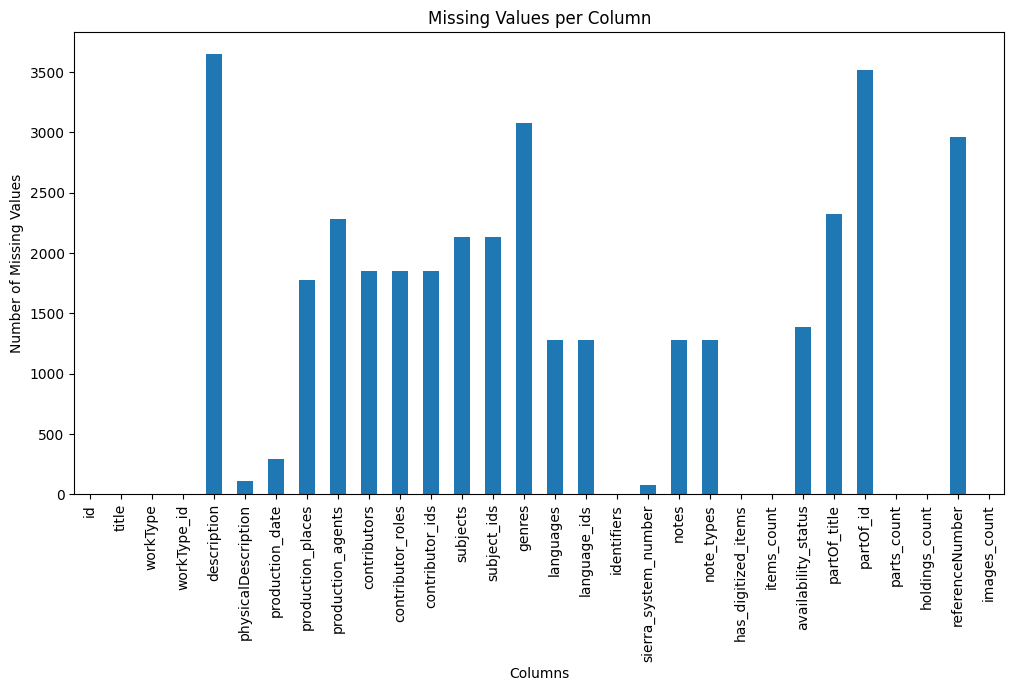


A random record from the dataframe:



,1901
id,yj4e69t3
title,"De Hage-professoren : geschiedenis van een chirurgische school / L. J. Endtz ; met medewerking van H. M. Mensonides, M. van Hasselt."
workType,Books
workType_id,a
description,None
physicalDescription,"172 pages : illustrations, portraits ; 21 cm"
production_date,"[1972], ©1972"
production_places,'s Gravenhage
production_agents,Nijgh & Van Ditmar
contributors,"Endtz, Lambertus J.; Hasselt, M. van.; Mensonides, H. M."


In [11]:
# shape of the dataset
print(f"\nOur filtered dataset has: {filtered.shape[1]} columns and {filtered.shape[0]} rows.")

# how many missing values per column
missing_values = filtered.isnull().sum()

plt.figure(figsize=(12,6))
plt.title("Missing Values per Column")
missing_values.plot(kind='bar')
plt.ylabel("Number of Missing Values")
plt.xlabel("Columns")
plt.show();

print_one_random_record(filtered)

We have now a dataframe more or less filtered but we still have a lot of columns that make no sense to use for our task, for example the _identifiers_. We will have to do some more __feature selection__.

In [12]:
# Remove non-predictable columns and with no corelation to the target
columns_to_remove = [
    # System IDs - just internal database identifiers, not predictable
    'id', 'workType_id', 'contributor_ids', 'subject_ids', 'language_ids', 
    'identifiers', 'sierra_system_number',
    
    # Counts - database metadata, not intrinsic properties of the work
    'items_count', 'parts_count', 'holdings_count', 'images_count',
    
    # Operational data - library-specific, not about the work itself
    'has_digitized_items', 'availability_status',
    
    # Less useful duplicates - keep the main version, remove auxiliary
    'note_types'  # Keep 'notes', remove the types since notes contain more info
]
necessary_df = filtered.copy().drop(columns=columns_to_remove);

# Display percentage of missing values per column with a custom styled table
null_pct = necessary_df.isnull().mean().sort_values(ascending=False) * 100
train_null = pd.DataFrame({
    "Column": null_pct.index,
    "% Null": [f"{v:.2f}%" for v in null_pct.values]
})

css = """
<style> 
.table-fixed {border-collapse: collapse; width: 70%; max-width: 900px;} 
.table-fixed th, 
.table-fixed td {border: 1px solid #ddd; padding: 6px 10px; text-align: left;} 
.table-fixed th {background:#808080; font-weight:600;} 
</style>
"""
print('We finally have only those columns left')
display(HTML(css + train_null.to_html(index=False, classes="table-fixed", escape=False)))

We finally have only those columns left


Column,% Null
description,72.96%
partOf_id,70.42%
genres,61.58%
referenceNumber,59.22%
partOf_title,46.40%
production_agents,45.62%
subjects,42.68%
contributors,37.00%
contributor_roles,37.00%
production_places,35.48%


In [13]:
print_one_random_record(necessary_df)


A random record from the dataframe:



,952
title,Robert Bridges : 1844-1930 / by Edward Thompson.
workType,Books
description,None
physicalDescription,"vii, 131 page"
production_date,[1944]
production_places,London
production_agents,Oxford University Press
contributors,Edward John Thompson
contributor_roles,Unknown
subjects,Robert Bridges


__Our dataset only contains columns that interest us.__ 

# Preprocessing
We now have to __preprocess__ the data. The goal is to predict missing values in the dataset using the other fields as input so we will not have to fill NaNs. But we still have to deal with classic preprocessings such as categorical variables encoding, text vectorization and normalization.

We do not want to _infect_ our testing dataset with the training one. So we split them before any normalization.

In [14]:
cumsum = necessary_df['production_places'].value_counts(normalize=True).cumsum()
print(f"We need the top {(cumsum <= 0.80).sum()} of the values to span 80% of all the production_places inside the dataset")
cumsum = necessary_df['languages'].value_counts(normalize=True).cumsum()
print(f"We need the top {(cumsum <= 0.95).sum()} of the values to span 95% of all the languages inside the dataset")
cumsum = necessary_df['workType'].value_counts(normalize=True).cumsum()
print(f"We need the top {(cumsum <= 0.95).sum()} of the values to span 95% of all the workType inside the dataset")


We need the top 357 of the values to span 80% of all the production_places inside the dataset
We need the top 15 of the values to span 95% of all the languages inside the dataset
We need the top 3 of the values to span 95% of all the workType inside the dataset


In [15]:
# We keep production_date in a separate column and the thumbnail URL too
columns_to_merge = [c for c in necessary_df.columns 
                    if c not in ["production_date", "thumbnail_url"]]

df_for_merge = necessary_df[columns_to_merge].copy()

def format_row(row):
    parts = []
    for col in row.index:
        col_upper = col.upper()
        value = row[col]

        if pd.isna(value):
            value = ""

        parts.append(f"[{col_upper}: {{{value}}}]")

    return " ".join(parts)

# Create MERGED in a separate dataframe
merged_df = pd.DataFrame()
merged_df["MERGED"] = df_for_merge.apply(format_row, axis=1)

# Add the two separated columns (from train)
merged_df["production_date"] = pd.to_numeric(
    necessary_df["production_date"], errors="coerce"
)

merged_df = merged_df.reset_index(drop = True)
print_one_random_record(merged_df)


A random record from the dataframe:



,2652
MERGED,"[TITLE: {Royal Society of Health}] [WORKTYPE: {Archives and manuscripts}] [DESCRIPTION: {Includes typescript accounts of meetings}] [PHYSICALDESCRIPTION: {1 file}] [PRODUCTION_PLACES: {}] [PRODUCTION_AGENTS: {}] [CONTRIBUTORS: {}] [CONTRIBUTOR_ROLES: {}] [SUBJECTS: {}] [GENRES: {}] [LANGUAGES: {}] [NOTES: {Description based on handlist by Peter Dickinson, with minor editing by Wellcome staff.}] [PARTOF_TITLE: {General files}] [PARTOF_ID: {y328sekn}] [REFERENCENUMBER: {PP/FDN/C/6}]"
production_date,NaN


In [16]:
train_test_ratio = 0.8
train = merged_df.sample(frac = train_test_ratio, random_state= 42)
test = merged_df.drop(train.index)
print(f"We decide to use {train_test_ratio*100}% of the data for the training.\n"
      f"Therefore we have a training sample of size {train.shape} and the test one of size {test.shape}")

We decide to use 80.0% of the data for the training.
Therefore we have a training sample of size (4000, 2) and the test one of size (1000, 2)


## Data Preprocessing Strategy

Our preprocessing pipeline is intentionally **minimal** - we leverage BERT's native ability to handle raw text and categorical data without explicit feature engineering.

### Target Variable

- **`production_date`**: Extract numeric year values from production_date strings via regex. This becomes our regression target.

### Minimal Preprocessing Rationale

Rather than traditional preprocessing (one-hot encoding, TF-IDF vectorization), we feed raw data directly to BERT for several reasons:

**Why not one-hot encode categorical features?**
- `workType` has only 16 unique values → trivial to one-hot encode
- But BERT embeddings capture semantic relationships better than binary vectors
- Example: "Book" and "Journal" are semantically closer than their one-hot representations suggest
- BERT learns distributed representations that preserve categorical meaning

**Why not TF-IDF for text?**
- TF-IDF treats words independently; BERT captures contextual relationships
- TF-IDF loses temporal signals (e.g., "1928" is just another term); BERT recognizes date expressions
- BERT handles variable-length sequences naturally without dimensionality reduction

**Direct comparison:** We compare TF-IDF + simple regressors against BERT embeddings + simple regressors to quantify improvement.

### Preprocessing Pipeline

1. **Merge Text Features**: Concatenate all text columns (title, description, notes, physicalDescription, partOf_title, production_places, production_agents, subjects, genres, languages, workType, contributors) into single text string with field separators

2. **Format for BERT**: Create input with structure:
```
   [TITLE: {title}] [DESC: {description}] [TYPE: {workType}] [LANG: {languages}] [SUBJ: {subjects}] ...
```
   Field labels help BERT distinguish information types

3. **Target Extraction**: Parse `production_date` → extract year as integer and not string

4. **Final Dataset**: Two columns:
   - `text`: Merged BERT input string
   - `year`: Target variable (numeric)

### Why This Works

BERT's transformer architecture:
- Handles variable text lengths without dimensionality reduction
- Learns categorical embeddings automatically through token representation
- Captures semantic relationships (e.g., "published 1950" → temporal context)
- No manual feature engineering needed

Result: Cleaner pipeline, better feature representations, comparison baseline (TF-IDF) included.

In [17]:
for col in train.columns:
    types = train[col].apply(lambda x: type(x).__name__).unique()
    print(col, "->", types)

MERGED -> ['str']
production_date -> ['float']


We merge all the column of the dataframe to simplify the format for BERT embeding. Only `thumbnail_url` and `production_date` are kept as they already are.

In [35]:
# We keep production_date in a separate column and the thumbnail URL too
columns_to_merge = [c for c in train.columns 
                    if c not in ["production_date", "thumbnail_url"]]

df_for_merge = train[columns_to_merge].copy()

def format_row(row):
    parts = []
    for col in row.index:
        col_upper = col.upper()
        value = row[col]

        if pd.isna(value):
            value = ""

        parts.append(f"[{col_upper}: {{{value}}}]")

    return " ".join(parts)

# Create MERGED in a separate dataframe
merged_train = pd.DataFrame()
merged_train["MERGED"] = df_for_merge.apply(format_row, axis=1)

# Add the two separated columns (from train)
merged_train["production_date"] = pd.to_numeric(
    train["production_date"], errors="coerce"
)

merged_train = merged_train.reset_index(drop = True)
print_one_random_record(merged_train)


A random record from the dataframe:



,43
MERGED,"[MERGED: {[TITLE: {The village doctor; or the art of curing diseases rendered familiar and easy; with select receipts / By I. Scott [i.e. James Scott].}] [WORKTYPE: {Books}] [DESCRIPTION: {}] [PHYSICALDESCRIPTION: {4 unnumbered leaves, 316 pages ; (12mo)}] [PRODUCTION_PLACES: {London}] [PRODUCTION_AGENTS: {Knight & Lacey}] [CONTRIBUTORS: {Scott, James (Surgeon)}] [CONTRIBUTOR_ROLES: {Unknown}] [SUBJECTS: {}] [GENRES: {}] [LANGUAGES: {English}] [NOTES: {}] [PARTOF_TITLE: {}] [PARTOF_ID: {}] [REFERENCENUMBER: {}]}]"
production_date,1824.0


## Data preprocess end


# Year Prediction with Frozen BERT + Modular Regression/Classification Heads

This part trains a frozen BERT encoder with interchangeable heads
for production year prediction.


In [18]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)

### Preparing the Data Loaders

In [19]:
def prepare_data(data):
    clean = data.dropna(subset=["production_date"]).copy()
    clean["production_date"] = pd.to_numeric(clean["production_date"], errors="coerce")
    clean = clean.dropna(subset=["production_date"])
    clean = clean[(clean["production_date"] >= 1400) & (clean["production_date"] <= 2030)]
    return clean

### Tokenizer

In [20]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Building the Bert 

In [25]:
def build_frozen_bert(model_name="bert-base-uncased"):
    bert = BertModel.from_pretrained(model_name)
    for p in bert.parameters():
        p.requires_grad = False
    return bert

frozen_bert = build_frozen_bert().to(DEVICE)

### Building the head

In [26]:
def build_head(
    task="regression",
    head_type="mlp",
    hidden_size=768,
    num_classes=None
):
    if task == "regression":
        if head_type == "linear":
            return nn.Linear(hidden_size, 1)

        if head_type == "mlp":
            return nn.Sequential(
                nn.Linear(hidden_size, 256),
                nn.ReLU(),
                nn.Linear(256, 1)
            )

        if head_type == "deep_mlp":
            return nn.Sequential(
                nn.Linear(hidden_size, 512),
                nn.ReLU(),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Linear(128, 1)
            )

    if task == "classification":
        assert num_classes is not None, "num_classes required for classification"

        if head_type == "linear":
            return nn.Linear(hidden_size, num_classes)

        if head_type == "mlp":
            return nn.Sequential(
                nn.Linear(hidden_size, 256),
                nn.ReLU(),
                nn.Linear(256, num_classes)
            )

        if head_type == "deep_mlp":
            return nn.Sequential(
                nn.Linear(hidden_size, 512),
                nn.ReLU(),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Linear(128, num_classes)
            )

    raise ValueError(f"Invalid task/head_type combination")

### Wrapping the frozen BERT and head into a single model

In [30]:
class FrozenBertModel(nn.Module):
    def __init__(self, bert, head):
        super().__init__()
        self.bert = bert
        self.head = head

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls = outputs.last_hidden_state[:, 0, :]
        return self.head(cls)


## Regression

### Dataset and DataLoader building

In [31]:
def build_dataloaders(df, tokenizer, batch_size=16):
    texts = df["MERGED"].tolist()
    labels = torch.tensor(df["normalized_year"].values, dtype=torch.float32).unsqueeze(1)

    tokens = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )

    dataset = TensorDataset(
        tokens["input_ids"],
        tokens["attention_mask"],
        labels
    )

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


### Train / Val split with normalization

In [32]:
def prepare_train_val(df):
    df = prepare_data(df)

    year_min = df["production_date"].min()
    year_max = df["production_date"].max()
    df["normalized_year"] = (df["production_date"] - year_min) / (year_max - year_min)

    train_df, val_df = train_test_split(
        df,
        test_size=0.15,
        random_state=SEED,
        stratify=pd.cut(df["production_date"], bins=10, labels=False)
    )

    return train_df, val_df, (year_min, year_max)

### Training Loop

In [33]:
def train_model(
    model,
    train_loader,
    val_loader,
    epochs=20,
    lr=2e-4,
    patience=3,
    min_delta=1e-4
):
    optimizer = torch.optim.AdamW(model.head.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.to(DEVICE)

    best_val_loss = float("inf")
    patience_counter = 0
    best_state = None

    for epoch in range(epochs):
        # =====================
        # Train
        # =====================
        model.train()
        train_loss = 0.0

        for input_ids, attention_mask, labels in train_loader:
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            preds = model(input_ids, attention_mask)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # =====================
        # Validate
        # =====================
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for input_ids, attention_mask, labels in val_loader:
                preds = model(
                    input_ids.to(DEVICE),
                    attention_mask.to(DEVICE)
                )
                val_loss += criterion(
                    preds, labels.to(DEVICE)
                ).item()

        val_loss /= len(val_loader)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train {train_loss:.4f} | "
            f"Val {val_loss:.4f}"
        )

        # =====================
        # Early Stopping Logic
        # =====================
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = {
                k: v.cpu().clone()
                for k, v in model.state_dict().items()
            }
        else:
            patience_counter += 1
            print(f"  ↳ No improvement ({patience_counter}/{patience})")

        if patience_counter >= patience:
            print("🛑 Early stopping triggered")
            break

    # Restore best model
    if best_state is not None:
        model.load_state_dict(best_state)

    return model

### Calling the training loop

In [ ]:
train_df, val_df, norm_params = prepare_train_val(merged_train)

train_loader = build_dataloaders(train_df, tokenizer, batch_size=16)
val_loader = build_dataloaders(val_df, tokenizer, batch_size=8)

head = build_head(head_type="deep_mlp") # simple mlp head 
model = FrozenBertModel(frozen_bert, head)

train_model(model, train_loader, val_loader, epochs=5);


### Save the model

In [39]:
os.makedirs("saved_model", exist_ok=True)
torch.save(model.state_dict(), "saved_model/pytorch_model.bin")
np.save("saved_model/norm_params.npy", np.array(norm_params))
tokenizer.save_pretrained("saved_model");

('saved_model/tokenizer_config.json',
 'saved_model/special_tokens_map.json',
 'saved_model/vocab.txt',
 'saved_model/added_tokens.json')

In [41]:
def load_and_predict_batched(
    test_data,
    model,
    tokenizer,
    norm_params,
    batch_size=8
):
    year_min, year_max = norm_params
    year_range = year_max - year_min

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    predictions = []

    for i in range(0, len(test_data), batch_size):
        batch_df = test_data.iloc[i:i + batch_size]

        tokens = tokenizer(
            batch_df['MERGED'].tolist(),
            padding="max_length",
            truncation=True,
            max_length=256,
            return_tensors="pt"
        )

        input_ids = tokens['input_ids'].to(device)
        attention_mask = tokens['attention_mask'].to(device)

        with torch.no_grad():
            preds = model(input_ids, attention_mask)

        preds = preds.squeeze(-1).cpu().numpy()
        predictions.extend(preds)

        # free GPU memory explicitly
        del input_ids, attention_mask, tokens, preds
        torch.cuda.empty_cache()

    test_data = test_data.copy()
    test_data['predicted_year'] = np.array(predictions) * year_range + year_min

    return test_data


print("\n" + "="*70)
print("PREPARING TEST DATA (ONLY LABELED ROWS)")
print("="*70)

# Keep only rows with real production_date
test_labeled = test.copy()
test_labeled["production_date"] = pd.to_numeric(
    test_labeled["production_date"], errors="coerce"
)

test_labeled = test_labeled.dropna(subset=["production_date"])
test_labeled = test_labeled[
    (test_labeled["production_date"] >= 1400) &
    (test_labeled["production_date"] <= 2030)
].reset_index(drop=True)

print(f"Labeled test rows: {len(test_labeled)}")

# Build MERGED only from labeled rows
columns_to_merge = [
    c for c in test_labeled.columns
    if c not in ["production_date", "thumbnail_url"]
]

df_for_merge = test_labeled[columns_to_merge].copy()

def format_row(row):
    parts = []
    for col in row.index:
        value = row[col]
        if pd.isna(value):
            value = ""
        parts.append(f"[{col.upper()}: {{{value}}}]")
    return " ".join(parts)

merged_test = pd.DataFrame()
merged_test["MERGED"] = df_for_merge.apply(format_row, axis=1)
merged_test["production_date"] = test_labeled["production_date"].values

# Predict
test_with_preds = load_and_predict_batched(
    merged_test,
    model,
    tokenizer,
    norm_params
)

print(test_with_preds[["production_date", "predicted_year"]].head())
def regression_metrics(df, year_col="production_date", pred_col="predicted_year"):
    """
    Compute regression metrics in *real years*
    """
    valid = df.dropna(subset=[year_col]).copy()
    valid = valid[(valid[year_col] >= 1400) & (valid[year_col] <= 2030)]

    if len(valid) == 0:
        print("No valid labels found.")
        return None

    errors = np.abs(valid[year_col] - valid[pred_col])

    metrics = {
        "n_samples": len(valid),
        "mae": errors.mean(),
        "median_ae": np.median(errors),
        "rmse": np.sqrt(np.mean((valid[year_col] - valid[pred_col]) ** 2)),
        "max_error": errors.max(),
        "min_error": errors.min(),
        "p25": np.percentile(errors, 25),
        "p50": np.percentile(errors, 50),
        "p75": np.percentile(errors, 75),
        "p90": np.percentile(errors, 90),
    }

    return metrics


metrics = regression_metrics(test_with_preds)
print(metrics)



PREPARING TEST DATA (ONLY LABELED ROWS)
Labeled test rows: 492
   production_date  predicted_year
0           1865.0     1925.352051
1           2014.0     1819.270264
2           1984.0     1990.257324
3           1976.0     2000.350830
4           1919.0     2021.784180
{'n_samples': 492, 'mae': np.float64(74.52301645666603), 'median_ae': np.float64(69.37890625), 'rmse': np.float64(90.10755020358542), 'max_error': 401.301513671875, 'min_error': 0.559326171875, 'p25': np.float64(39.96368408203125), 'p50': np.float64(69.37890625), 'p75': np.float64(96.5064697265625), 'p90': np.float64(131.38234863281255)}


## Metrics

In [ ]:

def compute_metrics(eval_pred):
    """Custom metrics for regression"""
    predictions, labels = eval_pred
    predictions = predictions.flatten()
    
    mae = np.mean(np.abs(predictions - labels))
    median_ae = np.median(np.abs(predictions - labels))
    rmse = np.sqrt(np.mean((predictions - labels) ** 2))
    
    return {
        'mae': mae,
        'median_ae': median_ae,
        'rmse': rmse,
    }

In [ ]:
def prepare_data(data):
    """Clean data: remove NaN and outliers"""
    clean = data.dropna(subset=['production_date']).copy()
    clean['production_date'] = pd.to_numeric(clean['production_date'], errors='coerce')
    clean = clean.dropna(subset=['production_date'])
    clean = clean[(clean['production_date'] >= 1400) & (clean['production_date'] <= 2025)]
    return clean


print("="*70)
print("STEP 1: DATA PREPARATION")
print("="*70)
    
print(f"Original size: {len(train)}")
train_data = prepare_data(train)
    
print(f"After cleaning: {len(train_data)}")
print(f"Year range: {train_data['production_date'].min():.0f} - {train_data['production_date'].max():.0f}")
print(f"Mean year: {train_data['production_date'].mean():.1f}")
print(f"Std year: {train_data['production_date'].std():.1f}")
    
if len(train_data) < 100:
    raise ValueError(f"Not enough training data! Got {len(train_data)}, need at least 100")

In [ ]:
print("STEP 2: LABEL NORMALIZATION")

# Normalize years to [0, 1] range for better training
year_min = train_data['production_date'].min()
year_max = train_data['production_date'].max()
year_range = year_max - year_min

train_data['normalized_year'] = (train_data['production_date'] - year_min) / year_range

print(f"Normalized range: [{train_data['normalized_year'].min():.3f}, {train_data['normalized_year'].max():.3f}]")

# Save normalization params for later
norm_params = {
    'year_min': float(year_min),
    'year_max': float(year_max),
    'year_range': float(year_range)
}

## Train Validation Set

In [ ]:

    
train_pd, val_pd = train_test_split(
    train_data, 
    test_size=0.15,  # 15% for validation
    random_state=42,
    stratify=pd.cut(train_data['production_date'], bins=10, labels=False)  # Stratify by year bins
    )
    
print(f"Train size: {len(train_pd)} ({len(train_pd)/len(train_data)*100:.1f}%)")
print(f"Val size: {len(val_pd)} ({len(val_pd)/len(train_data)*100:.1f}%)")
    
# Convert to HuggingFace datasets
train_hf = Dataset.from_pandas(train_pd.reset_index(drop=True))
val_hf = Dataset.from_pandas(val_pd.reset_index(drop=True))

## Tokenization

In [ ]:

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Check average text length to optimize max_length
avg_length = train_data['MERGED'].str.len().mean()
print(f"Average text length: {avg_length:.0f} characters")

# Important for fast or not
fast_mode = True

max_length = 256 if not fast_mode else 128

def tokenize(batch):
    return tokenizer(
        batch["MERGED"],
        truncation=True,
        padding="max_length",
        max_length=max_length
    )

print(f"Max sequence length: {max_length} tokens")

train_hf = train_hf.map(tokenize, batched=True, batch_size=1000)
val_hf = val_hf.map(tokenize, batched=True, batch_size=1000)

# Prepare for training (use normalized labels)
train_hf = train_hf.rename_column("normalized_year", "labels")
val_hf = val_hf.rename_column("normalized_year", "labels")
train_hf.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_hf.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

## Model initialization

In [ ]:

config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=1,
    problem_type="regression"  # Important!
)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    config=config,
    ignore_mismatched_sizes=True
)

print("Model initialized")

## Training 

###

In [ ]:

if fast_mode:
    print("FAST MODE - For quick testing")
    training_args = TrainingArguments(
        output_dir="./model_output",
        num_train_epochs=2,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        learning_rate=5e-5,
        warmup_ratio=0.1,
        weight_decay=0.01,
        eval_strategy="steps",
        eval_steps=100,
        save_strategy="steps",
        save_steps=100,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="mae",
        greater_is_better=False,
        save_total_limit=2,
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=0,
        report_to="none",
    )
else:
    print("PRODUCTION MODE - Best quality")
    training_args = TrainingArguments(
        output_dir="./model_output",
        
        # Training duration
        num_train_epochs=2,  # 3-5 epochs usually best
        
        # Batch sizes (adjust based on your GPU memory)
        per_device_train_batch_size=16,  # Smaller = more stable, larger = faster
        per_device_eval_batch_size=32,
        gradient_accumulation_steps=2,  # Effective batch size = 16 * 2 = 32
        
        # Learning rate (most important hyperparameter!)
        learning_rate=2e-5,  # 2e-5 to 5e-5 usually works best for BERT
        warmup_ratio=0.1,  # Warm up for 10% of training
        
        # Regularization
        weight_decay=0.01,  # Prevents overfitting
        
        # Evaluation and saving
        eval_strategy="epoch",  # Evaluate after each epoch
        save_strategy="epoch",
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="mae",
        greater_is_better=False,
        save_total_limit=3,  # Keep only best 3 checkpoints
        
        # Performance
        fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
        dataloader_num_workers=4 if torch.cuda.is_available() else 0,
        
        # Misc
        seed=42,
        report_to="none",  # Change to "wandb" if you want to track experiments
    )

### Train Prep

In [ ]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hf,
    eval_dataset=val_hf,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=3  # Stop if no improvement for 3 evaluations
        )
    ] if not fast_mode else [],
)

## Training

In [ ]:

print("This may take a while...")
print("GPU available:" if torch.cuda.is_available() else "Running on CPU (will be slower)")

trainer.train()


## Evaluation

In [ ]:
print("\n" + "="*70)
print("STEP 9: FINAL EVALUATION")
print("="*70)

eval_results = trainer.evaluate()
print("\nValidation Metrics:")
for key, value in eval_results.items():
    if key.startswith('eval_'):
        # Denormalize MAE back to years
        if 'mae' in key or 'median' in key or 'rmse' in key:
            value_in_years = value * year_range
            print(f"  {key}: {value:.4f} (normalized) = {value_in_years:.2f} years")
        else:
            print(f"  {key}: {value:.4f}")

## Saving model

In [ ]:
model_path="./saved_model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

# Save normalization parameters
with open(os.path.join(model_path, "norm_params.json"), "w") as f:
    json.dump(norm_params, f)

print(f"Model saved to: {model_path}")
print(f" Norms parameters saved to: {norm_params}")
print(f"Tokenizer saved")
print(f"Normalization params saved")

In [ ]:
def load_and_predict(test_data, model_path="./saved_model"):
    """
    Load trained model and make predictions
    """
    import json
    
    print("\n" + "="*70)
    print("LOADING MODEL AND PREDICTING")
    print("="*70)
    
    # Load normalization params
    with open(os.path.join(model_path, "norm_params.json"), "r") as f:
        norm_params = json.load(f)
    
    year_min = norm_params['year_min']
    year_max = norm_params['year_max']
    year_range = norm_params['year_range']
    
    print(f"Normalization params: min={year_min:.0f}, max={year_max:.0f}, range={year_range:.0f}")
    
    # Load model and tokenizer
    model = DistilBertForSequenceClassification.from_pretrained(model_path)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    
    print("✓ Model and tokenizer loaded")
    
    # Tokenize
    def tokenize(batch):
        return tokenizer(
            batch["MERGED"],
            truncation=True,
            padding="max_length",
            max_length=256  # Match training
        )
    
    test_pd = test_data.copy().reset_index(drop=True)
    test_hf = Dataset.from_pandas(test_pd)
    test_hf = test_hf.map(tokenize, batched=True, batch_size=1000)
    test_hf.set_format("torch", columns=["input_ids", "attention_mask"])
    
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="./tmp_predict",
            per_device_eval_batch_size=32,
            dataloader_num_workers=0,
            report_to="none",
        ),
    )

    print("Making predictions...")
    preds = trainer.predict(test_hf).predictions
    # Denormalize predictions back to years
    test_pd["predicted_year"] = preds * year_range + year_min
    
    print("✓ Predictions complete")
    
    return test_pd

## BERT

In [ ]:
# Predict
test_with_predictions = load_and_predict(test, model_path)

print("\nSample predictions:")
display_cols = ["predicted_year"]
if "production_date" in test_with_predictions.columns:
    display_cols.insert(0, "production_date")

print(test_with_predictions[display_cols].head(10))

# Calculate metrics
if "production_date" in test_with_predictions.columns:
    valid = test_with_predictions.dropna(subset=['production_date'])
    valid = valid[(valid['production_date'] >= 1400) & (valid['production_date'] <= 2030)]
    
    if len(valid) > 0:
        valid["error"] = abs(valid["production_date"] - valid["predicted_year"])
        
        print(f"\n{'='*70}")
        print("TEST SET PERFORMANCE")
        print("="*70)
        print(f"Valid samples: {len(valid)}/{len(test_with_predictions)}")
        print(f"MAE: {valid['error'].mean():.2f} years")
        print(f"Median Error: {valid['error'].median():.2f} years")
        print(f"RMSE: {np.sqrt((valid['error']**2).mean()):.2f} years")
        print(f"Max Error: {valid['error'].max():.2f} years")
        print(f"Min Error: {valid['error'].min():.2f} years")
        
        # Error percentiles
        print(f"\nError Percentiles:")
        print(f"  25th percentile: {valid['error'].quantile(0.25):.2f} years")
        print(f"  50th percentile: {valid['error'].quantile(0.50):.2f} years")
        print(f"  75th percentile: {valid['error'].quantile(0.75):.2f} years")
        print(f"  90th percentile: {valid['error'].quantile(0.90):.2f} years")
